In [247]:
import torch
from torchvision import datasets, transforms
import torchvision
from torchvision import models
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import random

In [248]:
'''SETTING UP U-NET NEURAL NETWORK'''

class Block(nn.Module):
    '''
    Block has three layers: two convolution operators (no padding)
    and one with ReLU activation
    '''
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 5, padding='same')
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 5, padding='same')        
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    '''
    Encoder: Maxpooling (used for downsampling) performed between two Block operations
    This class includes the block operations already
    '''
    def __init__(self, chs=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    '''
    Decoder: Series of upconvolutions and decoders to expand matrix in order to determine location
    '''
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    '''
    Code to set up encoders and decoder layers
    '''
    def __init__(self, enc_chs=(1,2,4,8,16,32), dec_chs=(32, 16,8, 4, 2), num_class=3, retain_dim=True, out_sz=(1024,1024)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        #self.retain_dim  = retain_dim

    def forward(self, x, out_sz=(256,256)):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        
        #if self.retain_dim:
            #out = nn.functional.interpolate(out, out_sz)
            
        return out

In [249]:
'''SETUP DATASETS'''

def normalization(x):
    '''
    Used to normalize sample data so that it is between 0 and 1
    '''
#     x_max = torch.max(x)
#     x_min = torch.min(x)
#     x_norm = (x-x_min)/(x_max-x_min)
    
    x_mean = torch.mean(x)
    x_stdev = torch.std(x)
    x_norm = (x-x_mean)/(x_stdev)
    return x_norm

def rand_input(x, **kwargs):
    
    val = torch.rand(3).to(device)
    x = torch.where(x==0,val[0],x)
    x = torch.where(x==1, val[1],x)
    x = torch.where(x==2, val[2],x)
    return x


class Dataset(Dataset):
#'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # In order to handle different indexing for validation and training data
        while True:
            try:
                ID = self.list_IDs[index]
                break
            except:
                index += len(self.list_IDs)
        # Load data and get label
        X = torch.load(ID)
        x_rand = rand_input(X['target'])
        x_rand += 0.1*torch.rand(x_rand.shape)
        X['input'] = normalization(x_rand)
        return X

In [250]:
'''FUNCTIONS'''

def cuda_setup():
    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    torch.backends.cudnn.benchmark = True
    print("Using {} device".format(device))
    
    return(device)

def set_rand_seed(seed):
    '''
    Creates random seed for each library so that randomness is repeatable. Initialized first to set all randomness
    '''
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)



# def optimization_plots(x, y):
#     # x: epoch number, y: training
#     plt.plot(x, y)
#     plt.xlabel("Epoch Number")
#     plt.ylabel("Loss")
#     plt.title("Learning Plot")
#     plt.show()

def save_params(output_array, orig_array, params, desc, loss, model, optimizer, i):
    '''
    Saves what I have changed in each iteration
    
    Inputs:
        Long string of output graphs
        List of params
        Comments of what was changed. 
    Outputs: 
        Pytorch file which lists all of these in a dictionary
    '''
    
    output_tensor = torch.Tensor(output_array)
    orig_tensor = torch.Tensor(orig_array)
    
    torch.save({
        "output": output_tensor, 
        "original": orig_tensor, 
        "params":params, 
        "description": desc, 
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss}, 
        f"/nsls2/users/maire1/unet/params_list{i}.pt")
    i += 1
    return i

def calculate_weights(target):
    #t = normalization(target)
    total = target.numel()
    stop = target.eq(2).sum().item()/2
    streaks = target.eq(1).sum().item()
    bkgnd = total - streaks - stop
    if streaks == 0 and stop == 0:
        weights = [1, 1, 1]
    elif streaks == 0:
        weights = [1, 1, bkgnd/stop]
    elif stop == 0:
        weights = [1, bkgnd/streaks, 1]
    else:
        weights = [1, bkgnd/streaks, bkgnd/stop]
    return weights

def rand_input(x, **kwargs):
    val = torch.rand(3)
    x = torch.where(x==0, val[0],x)
    x = torch.where(x==1, val[1],x)
    x = torch.where(x==2, val[2],x)
    return x

In [251]:
def train(dataloader, model, optimizer, device, training_graphs, orig_images):
    size = len(dataloader)
    model.train()
    loss_tot = np.zeros(size)
    
    for batch_num, local_batch in enumerate (dataloader):

        # Transfer to GPU
        for key, value in local_batch.items():
            local_batch[key] = value.to(device)
        in_batch = local_batch['input'].unsqueeze(1)
#         in_batch = local_batch['target'].unsqueeze(1)
        
#         in_batch_norm = normalization(in_batch)
#         in_batch_rand = rand_input(in_batch_norm)
        out  = model(in_batch)
        #out = model(in_batch)
        target = local_batch['target']
        
        #WEIGHTS
        weight = calculate_weights(target)
        class_weight = torch.FloatTensor(weight).to(device)
        loss_fn = nn.CrossEntropyLoss(class_weight)
        
        #print(target.type(), target.shape, out.type(), out.shape)
        
        loss = loss_fn(out, target.long())

#         #GRAPHING
#         nn_image = out.argmax(1)
#         nn_image = nn_image[0,:,:].cpu().numpy()
#         training_graphs.append(nn_image)
        
#         y_graph = in_batch[0,0,:,:].cpu().numpy()
#         orig_images.append(y_graph)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.cpu().detach()
        
        loss, current = loss.item(), batch_num #* len(out)
        # print(f"loss: {loss:>7f}  [{(current+1):>5d}/{size:>5d}]")
        loss_tot[batch_num] = loss
        
        if torch.cuda.torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    mean = np.mean(loss_tot)
    print("Train Mean Loss: ", mean)
    

    #GRAPHING CTD.
    for i in range (len(training_graphs)):
        plt.imshow(training_graphs[i])
        plt.show()

        plt.imshow(orig_images[i])
        plt.show()

    return training_graphs, orig_images, loss, optimizer
    
                
def validation(dataloader, model, device):
    
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for batch_num, local_batch in enumerate (dataloader):
            # Transfer to GPU
            
            for key, value in local_batch.items():
                local_batch[key] = value.to(device)
                
            #pred = model(local_batch['input'].unsqueeze(1))
            y = local_batch['target']
            #pred = model(y.unsqueeze(1))
            
            in_val = local_batch['input'].unsqueeze(1)
#             in_val_norm = normalization(in_val)
#             in_val_rand = rand_input(in_val_norm)
            pred = model(in_val)
            
            
            #WEIGHTS
            weight = calculate_weights(y)
            class_weight = torch.FloatTensor(weight).to(device)
            loss_fn = nn.CrossEntropyLoss(class_weight) 
            
            test_loss += loss_fn(pred, y.long())#.detach()
            
            correct += (pred.argmax(axis=1) == y).type(torch.float).sum()
            #correct += (pred.argmax(1) == y).type(torch.float).sum()#.detach()
            tot_pts = torch.numel(y)
            

        size = batch_num + 1
        test_loss /= size
        #print ("Correct:", correct.shape(), "\nTotal Size: ", size*tot_pts)
        correct /= (size*tot_pts)
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        
        if torch.cuda.torch.cuda.is_available():
            torch.cuda.empty_cache() 

In [252]:
params = {'batch_size': 4, #Number of samples in each batch
          'shuffle': True,
          'num_workers': 0} #Number of process to generate batches in //
max_epochs = 33 
learning_rate = 1e-2
num = 0 #FOR RANDOM SEED

set_rand_seed(num)

#Init
output_array = []
orig_array = []
desc = "First saving run. Only trained on the mask input"

#Training
datafile = "data/sim_address.csv"

#def main(datafile, params, max_epochs):
    
# Determine and setup device
device = cuda_setup()

# Datasets
file = pd.read_csv(datafile)
partition = file['address']# IDs
training_partition = partition[:800]
validation_partition = partition[800:]

labels = file['sample']# Labels
training_labels = labels[:800]
validation_labels = labels[800:]

model = UNet().to(device) #comment this out when you start training

# Generators
training_set = Dataset(training_partition, training_labels)
training_generator = DataLoader(training_set, **params, pin_memory=True)

validation_set = Dataset(validation_partition, validation_labels)
validation_generator = DataLoader(validation_set, **params, pin_memory=True)
# images, masks = next(iter(training_generator))['input'], next(iter(training_generator))['target']


# weight = calculate_weights()
# class_weight = torch.FloatTensor(weight).to(device)
# loss_fn = nn.CrossEntropyLoss(class_weight)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Loop over epochs
for epoch in range(max_epochs):
    # Training
    print(f"Epoch {epoch+1}\n-------------------------------")
    output_array, orig_array, loss, optimizer = train(training_generator, model, optimizer, device, training_graphs=output_array, orig_images=orig_array)
    validation(validation_generator, model, device)
    
#i = save_params(output_array, orig_array, params, desc, loss, model, optimizer)
    

Using cuda:0 device
Epoch 1
-------------------------------
Train Mean Loss:  1.122728858292103
Test Error: 
 Accuracy: 1.4%, Avg loss: 1.055239
Epoch 2
-------------------------------
Train Mean Loss:  1.0442604821920396
Test Error: 
 Accuracy: 1.4%, Avg loss: 1.034322
Epoch 3
-------------------------------
Train Mean Loss:  1.0332522270083428
Test Error: 
 Accuracy: 1.4%, Avg loss: 1.027568
Epoch 4
-------------------------------
Train Mean Loss:  1.0208672806620598
Test Error: 
 Accuracy: 1.4%, Avg loss: 1.018069
Epoch 5
-------------------------------
Train Mean Loss:  0.997128456234932
Test Error: 
 Accuracy: 1.4%, Avg loss: 0.982789
Epoch 6
-------------------------------
Train Mean Loss:  0.9701462984085083
Test Error: 
 Accuracy: 1.4%, Avg loss: 0.956130
Epoch 7
-------------------------------
Train Mean Loss:  0.9526163324713707
Test Error: 
 Accuracy: 1.4%, Avg loss: 0.940855
Epoch 8
-------------------------------
Train Mean Loss:  0.9337377887964249
Test Error: 
 Accuracy:

In [244]:
local_batch = next(iter(training_generator))
x = local_batch['input'].unsqueeze(1).to(device)
# x_r = rand_input(x)
# x_norm = normalization(x_r)
x_hat = model(x)

Text(0.5, 1.0, 'target')

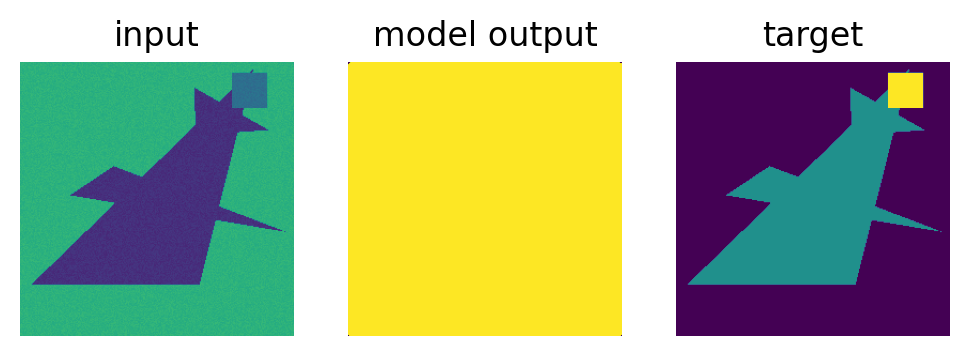

In [246]:
fig, ax = plt.subplots(1, 3, dpi = 200)

k =2

ax[0].imshow(x[k, 0, :, :].cpu().detach().numpy(), vmin = -1, vmax = 1)
ax[1].imshow(x_hat[k, :, :, :].cpu().detach().numpy().argmax(0), vmin = 0, vmax = 2)
ax[2].imshow(local_batch['target'][k])
for j in range(3):
    ax[j].axis('off')
    
ax[0].set_title('input')
ax[1].set_title('model output')
ax[2].set_title('target')

In [ ]:
# RUNNING CELL
#------------------------------------------------

# Parameters
params = {'batch_size': 2, #Number of samples in each batch
          'shuffle': True,
          'num_workers': 0} #Number of process to generate batches in //
max_epochs = 4

#Training
datafile = "/nsls2/users/maire1/sim_data/sim_address.csv"

main(datafile, params, max_epochs)

#### Messing around with the code

In [ ]:
params = {'batch_size': 1, #Number of samples in each batch
          'shuffle': True,
          'num_workers': 0} #Number of process to generate batches in //
max_epochs = 4

#Training
datafile = "/nsls2/users/maire1/sim_data/sim_address.csv"

#def main(datafile, params, max_epochs):
    
# Determine and setup device
device = cuda_setup()

# Datasets
file = pd.read_csv(datafile)
partition = file['address']# IDs
training_partition = partition[:80]
validation_partition = partition[80:]

labels = file['sample']# Labels
training_labels = labels[:80]
validation_labels = labels[80:]

model = UNet().to(device)

arr  = torch.rand([2,1,256,256]).float().to(device)
model(arr)

# size = len(dataloader)

# #for batch_num, local_batch in enumerate (dataloader):
    
#     # Transfer to GPU
#     for key, value in local_batch.items():
#         local_batch[key] = value.to(device)

#     in_batch = local_batch['input'].unsqueeze(1)
#     print(in_batch.shape)
#     out  = model(in_batch)

#     #flatten target
#     target = local_batch['target']
#     loss = loss_fn(out, target.long()).cpu().detach()

#     # Backpropagation
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     #if batch_num % 100 == 0:
#     loss, current = loss.item(), batch_num #* len(out)
#     print(f"loss: {loss:>7f}  [{(current+1):>5d}/{size:>5d}]")

#     del in_batch, out, local_batch, target, loss, current, size, batch
#     if torch.cuda.torch.cuda.is_available():
#         torch.cuda.empty_cache()

In [ ]:
del in_batch

In [ ]:
local_batch = next(iter(training_generator))


for key, value in local_batch.items():
    local_batch[key] = value.to(device)
        
in_batch = local_batch['input'].unsqueeze(1)
out  = model(in_batch)



In [ ]:
# RUNNING CELL
#------------------------------------------------

# Parameters
params = {'batch_size': 2, #Number of samples in each batch
          'shuffle': True,
          'num_workers': 0} #Number of process to generate batches in //
max_epochs = 4

#Training
datafile = "/nsls2/users/maire1/sim_data/sim_address.csv"

main(datafile, params, max_epochs)

In [ ]:
model

mean squared error loss. y as target (y-y^)^2